In [4]:
import serial
import serial.tools.list_ports
import time
import csv
import os
from datetime import datetime
from collections import deque

# Function to find available COM ports
def find_available_ports():
    ports = serial.tools.list_ports.comports()
    available_ports = []
    for port in ports:
        print(f"Found port: {port.device} - {port.description}")
        available_ports.append(port.device)
    return available_ports

# Create data directory if it doesn't exist
data_dir = "breathing_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Create filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = os.path.join(data_dir, f"breathing_data_{timestamp}.csv")

# Also create a "latest" file for easy access
latest_filename = os.path.join(data_dir, "latest_breathing_data.csv")

print(f"Data will be saved to: {csv_filename}")

# List available ports
print("Available COM ports:")
available_ports = find_available_ports()

# Try to connect to the first available port or specify manually
if available_ports:
    com_port = available_ports[0]  # Use first available port
    print(f"Attempting to connect to: {com_port}")
else:
    com_port = "COM10"  # Fallback to original port
    print(f"No ports detected, trying: {com_port}")

# Initialize ser variable
ser = None

# Open serial port with error handling
try:
    ser = serial.Serial(com_port, 115200, timeout=1)
    print(f"Successfully connected to {com_port}")
except serial.SerialException as e:
    print(f"Failed to open {com_port}: {e}")
    print("Please check:")
    print("1. Device is connected")
    print("2. Correct COM port number")
    print("3. Close any other applications using the port")
    print("4. Run as administrator if needed")
    ser = None

# Only proceed if connection was successful
if ser is not None:
    # Wait for device to finish booting
    print("Waiting for device initialization...")
    time.sleep(3)  # Give device time to boot up
    
    # Clear any remaining boot messages
    ser.reset_input_buffer()
    
    data_count = 0
    
    # Initialize CSV files
    with open(csv_filename, 'w', newline='') as csvfile, \
         open(latest_filename, 'w', newline='') as latest_file:
        
        # Create CSV writers
        csv_writer = csv.writer(csvfile)
        latest_writer = csv.writer(latest_file)
        
        # Write headers
        csv_writer.writerow(['Sample', 'Timestamp', 'Pressure_hPa'])
        latest_writer.writerow(['Sample', 'Timestamp', 'Pressure_hPa'])
        
        print("Starting data collection...")
        print("Press Ctrl+C to stop data collection")
        print("Data is being saved in real-time...")
        
        try:
            while True:
                try:
                    if ser.in_waiting > 0:  # Check if data is available
                        line_data = ser.readline().decode("utf-8").strip()
                        if line_data:
                            try:
                                pressure = float(line_data)
                                data_count += 1
                                
                                # Get current timestamp
                                current_time = datetime.now().strftime("%H:%M:%S.%f")[:-3]
                                
                                # Write to both CSV files
                                row_data = [data_count, current_time, pressure]
                                csv_writer.writerow(row_data)
                                latest_writer.writerow(row_data)
                                
                                # Flush to ensure data is written immediately
                                csvfile.flush()
                                latest_file.flush()
                                
                                # Print every 10th value for monitoring
                                if data_count % 10 == 0:
                                    print(f"Sample {data_count}: {pressure} hPa at {current_time}")
                                
                                # Print summary every 100 samples
                                if data_count % 100 == 0:
                                    print(f"--- {data_count} samples collected and saved ---")
                                
                            except ValueError:
                                # Skip non-numeric data (boot messages, etc.)
                                if not any(skip_word in line_data for skip_word in ["BMP280", "load:", "configsip", "clk_drv", "mode:", "entry", "FLASH_BOOT"]):
                                    print(f"Skipping non-numeric data: {line_data}")
                                continue
                                
                except serial.SerialException as e:
                    print(f"Serial communication error: {e}")
                    break
                except KeyboardInterrupt:
                    print("\nStopping data collection...")
                    break

        finally:
            print(f"\nData collection stopped. {data_count} samples collected.")
            print(f"Data saved to: {csv_filename}")
            print(f"Latest data also saved to: {latest_filename}")

    # Close serial connection
    if ser is not None and ser.is_open:
        ser.close()
        print("Serial port closed")
    
    print(f"\nData collection complete!")
    print(f"Total samples: {data_count}")
    print(f"Files created:")
    print(f"  - {csv_filename}")
    print(f"  - {latest_filename}")
    
else:
    print("Cannot start data collection - no serial connection established")

Data will be saved to: breathing_data\breathing_data_20250828_121320.csv
Available COM ports:
Found port: COM10 - Silicon Labs CP210x USB to UART Bridge (COM10)
Attempting to connect to: COM10
Successfully connected to COM10
Waiting for device initialization...
Starting data collection...
Press Ctrl+C to stop data collection
Data is being saved in real-time...
Sample 10: 1008.3 hPa at 12:13:23.620
Sample 20: 1008.28 hPa at 12:13:23.828
Sample 30: 1008.28 hPa at 12:13:24.038
Sample 40: 1008.3 hPa at 12:13:24.248
Sample 50: 1008.32 hPa at 12:13:24.460
Sample 60: 1008.29 hPa at 12:13:24.668
Sample 70: 1008.29 hPa at 12:13:24.878
Sample 80: 1008.28 hPa at 12:13:25.088
Sample 90: 1008.26 hPa at 12:13:25.298
Sample 100: 1008.32 hPa at 12:13:25.511
--- 100 samples collected and saved ---
Sample 110: 1008.33 hPa at 12:13:25.720
Sample 120: 1008.38 hPa at 12:13:25.928
Sample 130: 1008.36 hPa at 12:13:26.138
Sample 140: 1008.38 hPa at 12:13:26.349
Sample 150: 1008.38 hPa at 12:13:26.558
Sample 1

Loading latest breathing data...
Loaded 7081 data points from breathing_data\latest_breathing_data.csv

Data Statistics:
Pressure range: 1008.230 - 1008.450 hPa
Pressure mean: 1008.342 hPa
Pressure std: 0.027 hPa


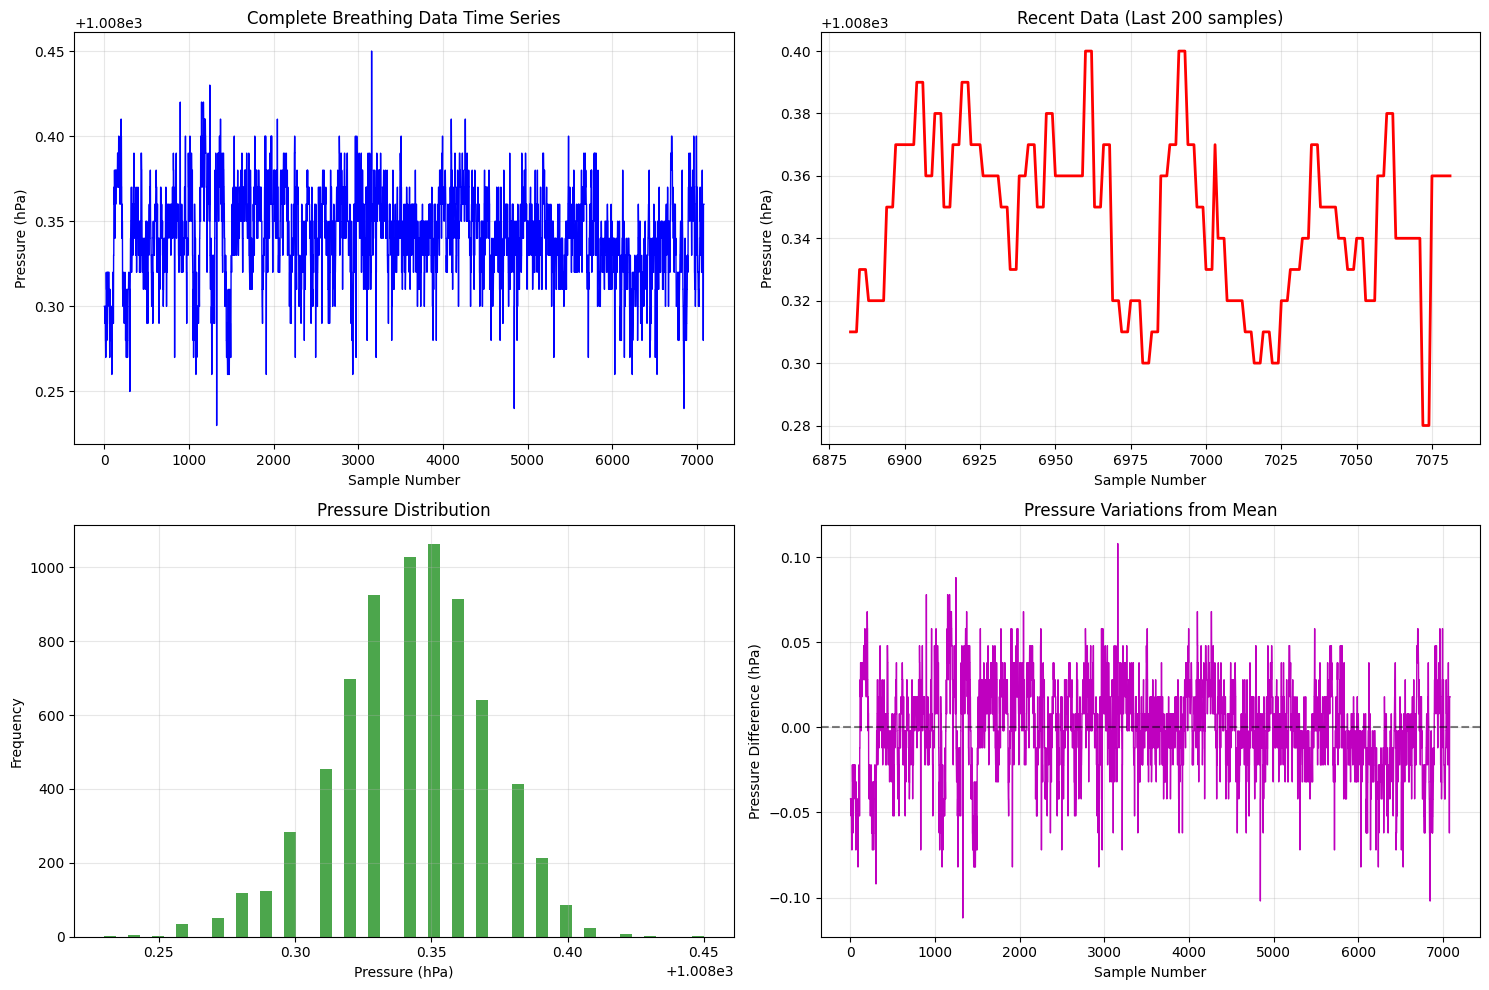


Creating breathing pattern analysis...


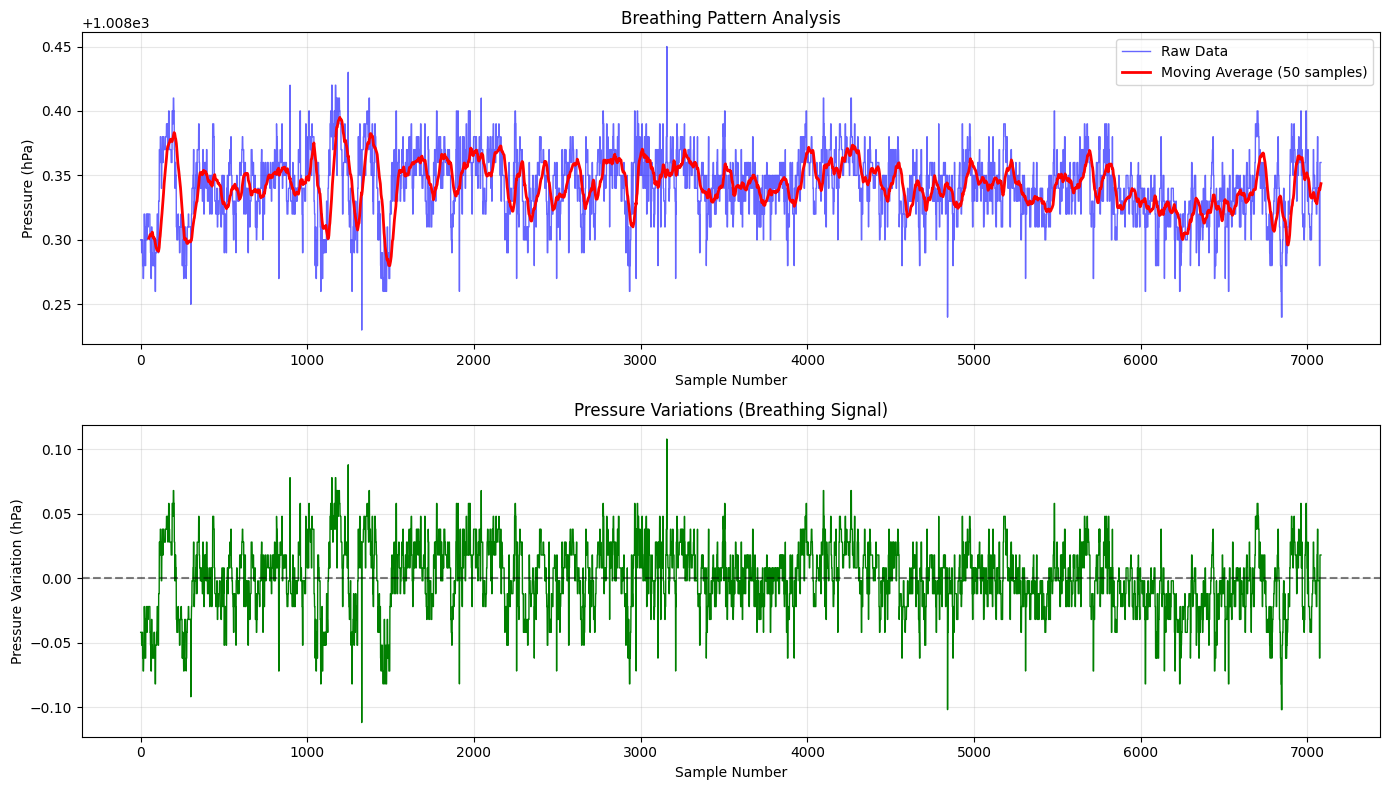

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Set matplotlib backend for Jupyter
%matplotlib inline

def load_and_plot_breathing_data(filename=None):
    """
    Load breathing data from CSV file and create visualizations
    """
    data_dir = "breathing_data"
    
    if filename is None:
        # Use the latest data file
        latest_filename = os.path.join(data_dir, "latest_breathing_data.csv")
        if os.path.exists(latest_filename):
            filename = latest_filename
        else:
            # Find the most recent file
            csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f.startswith('breathing_data_')]
            if csv_files:
                csv_files.sort()
                filename = os.path.join(data_dir, csv_files[-1])
            else:
                print("No breathing data files found!")
                return None
    
    try:
        # Load data from CSV
        df = pd.read_csv(filename)
        print(f"Loaded {len(df)} data points from {filename}")
        
        # Basic statistics
        print(f"\nData Statistics:")
        print(f"Pressure range: {df['Pressure_hPa'].min():.3f} - {df['Pressure_hPa'].max():.3f} hPa")
        print(f"Pressure mean: {df['Pressure_hPa'].mean():.3f} hPa")
        print(f"Pressure std: {df['Pressure_hPa'].std():.3f} hPa")
        
        # Create comprehensive plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Full time series
        axes[0, 0].plot(df['Sample'], df['Pressure_hPa'], 'b-', linewidth=1)
        axes[0, 0].set_title('Complete Breathing Data Time Series')
        axes[0, 0].set_xlabel('Sample Number')
        axes[0, 0].set_ylabel('Pressure (hPa)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Zoomed view (last 200 points or all if less)
        zoom_points = min(200, len(df))
        zoom_data = df.tail(zoom_points)
        axes[0, 1].plot(zoom_data['Sample'], zoom_data['Pressure_hPa'], 'r-', linewidth=2)
        axes[0, 1].set_title(f'Recent Data (Last {zoom_points} samples)')
        axes[0, 1].set_xlabel('Sample Number')
        axes[0, 1].set_ylabel('Pressure (hPa)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Histogram of pressure values
        axes[1, 0].hist(df['Pressure_hPa'], bins=50, alpha=0.7, color='green')
        axes[1, 0].set_title('Pressure Distribution')
        axes[1, 0].set_xlabel('Pressure (hPa)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Pressure variations from mean
        mean_pressure = df['Pressure_hPa'].mean()
        pressure_diff = df['Pressure_hPa'] - mean_pressure
        axes[1, 1].plot(df['Sample'], pressure_diff, 'm-', linewidth=1)
        axes[1, 1].set_title('Pressure Variations from Mean')
        axes[1, 1].set_xlabel('Sample Number')
        axes[1, 1].set_ylabel('Pressure Difference (hPa)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def plot_breathing_pattern(df, window_size=50):
    """
    Analyze and plot breathing patterns
    """
    if df is None or len(df) == 0:
        print("No data to analyze")
        return
    
    # Calculate moving average to smooth the data
    df['Moving_Avg'] = df['Pressure_hPa'].rolling(window=window_size).mean()
    
    # Create breathing pattern analysis
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Sample'], df['Pressure_hPa'], 'b-', alpha=0.6, linewidth=1, label='Raw Data')
    plt.plot(df['Sample'], df['Moving_Avg'], 'r-', linewidth=2, label=f'Moving Average ({window_size} samples)')
    plt.title('Breathing Pattern Analysis')
    plt.xlabel('Sample Number')
    plt.ylabel('Pressure (hPa)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot pressure variations
    plt.subplot(2, 1, 2)
    mean_pressure = df['Pressure_hPa'].mean()
    variations = df['Pressure_hPa'] - mean_pressure
    plt.plot(df['Sample'], variations, 'g-', linewidth=1)
    plt.title('Pressure Variations (Breathing Signal)')
    plt.xlabel('Sample Number')
    plt.ylabel('Pressure Variation (hPa)')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Load and plot the data
print("Loading latest breathing data...")
data = load_and_plot_breathing_data()

if data is not None:
    print("\nCreating breathing pattern analysis...")
    plot_breathing_pattern(data)
else:
    print("No data available to plot. Please run the data collection script first.")